In [ ]:
################################################################################
#####################  Xgboost HPO GPU for 2018 - 2020 #########################
############# Train 2020 Test 2018-19 & Train 2018-19 Test 2020 ################
################################################################################

In [26]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
import joblib
from hyperopt import STATUS_OK
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
from eli5 import show_prediction
import shap

     |████████████████████████████████| 564 kB 4.2 MB/s 


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Set seed 
seed_value = 42
os.environ['XgboostGPU_train20test1819'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6703389, 22)


In [ ]:
# Drop time and COVID-19 vars
df = df.drop(['State', 'DateTime', 'Date_Weekly_COVID', 'DateTime_YearWeek'],
             axis=1)

In [ ]:
# Convert dtypes
df = df.copy()
df['State_Closure_EA_Diff'] = df['State_Closure_EA_Diff'].astype('float64')
df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('object')

In [ ]:
# Filter missing data
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()]

In [ ]:
# Filter df to 2020
df = df[df['Year'] == 2020]

# Drop year variable
df = df.drop(['Year'], axis=1)

In [ ]:
# Prepare 2020 for partitioning data
X = df.drop(['Metric_Tons'], axis=1)
y = df['Metric_Tons']

del df

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [ ]:
# Training set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)

# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Test: Create dummy variables for categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(mn.fit_transform(X_test), columns = X_test.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeImportsExports/ML/Xgboost/trialOptions/

In [ ]:
# Access results
results = pd.read_csv('Xgboost_HPO_train20test20_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeImportsExports/ML/Xgboost/Model_PKL/

In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    random_state = seed_value, 
                                    **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_train20test20_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_train20test20_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Train 2020 Test 2020 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for Xgboost HPO Train 2020 Test 2020 100 GPU trials
MAE train: 4.220, test: 8.050
MSE train: 67.536, test: 258.625
RMSE train: 8.218, test: 16.082
R^2 train: 0.891, test: 0.581


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 258.62480 MSE on the test set.
This was achieved after 84 search iterations


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

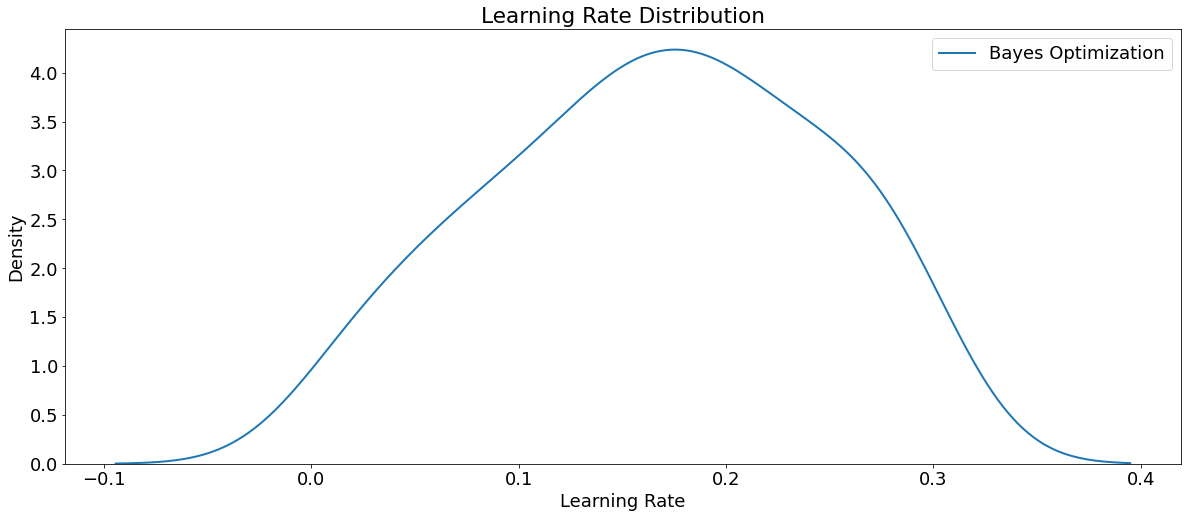

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

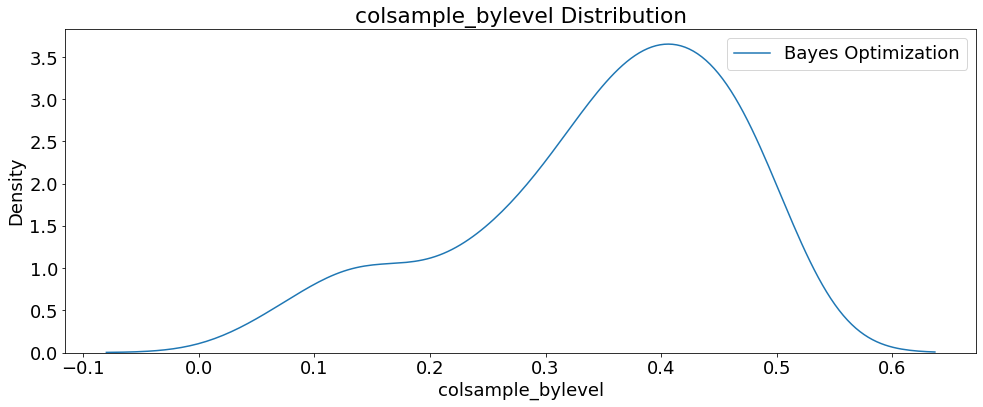

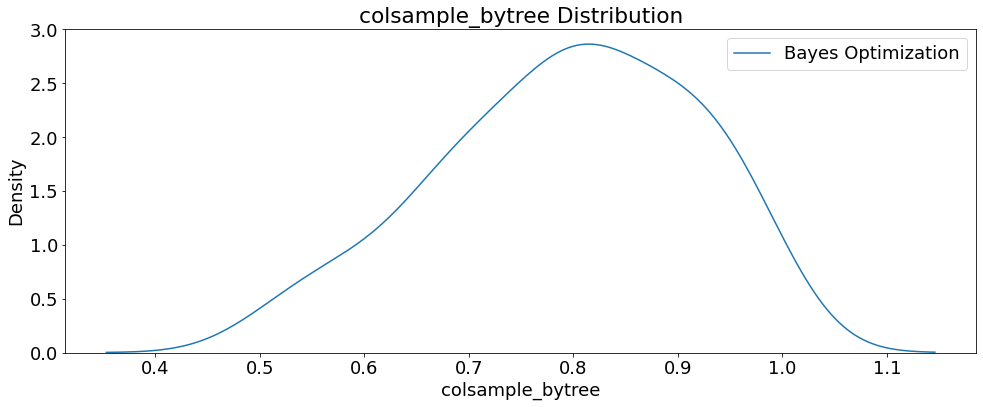

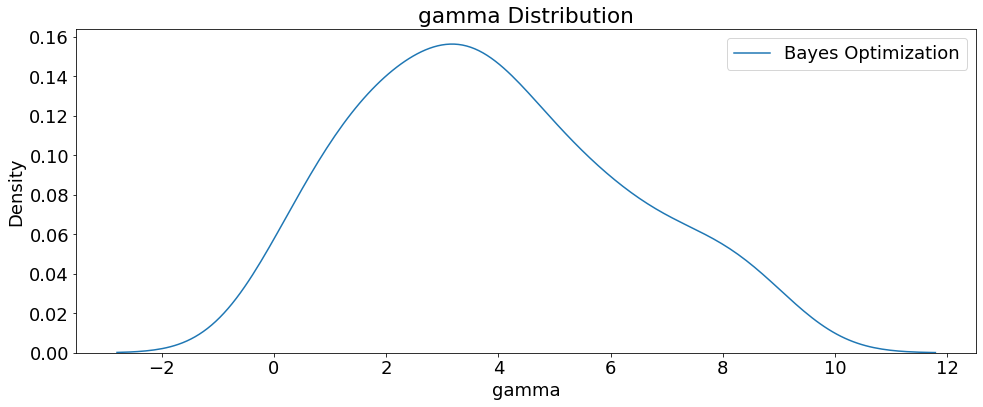

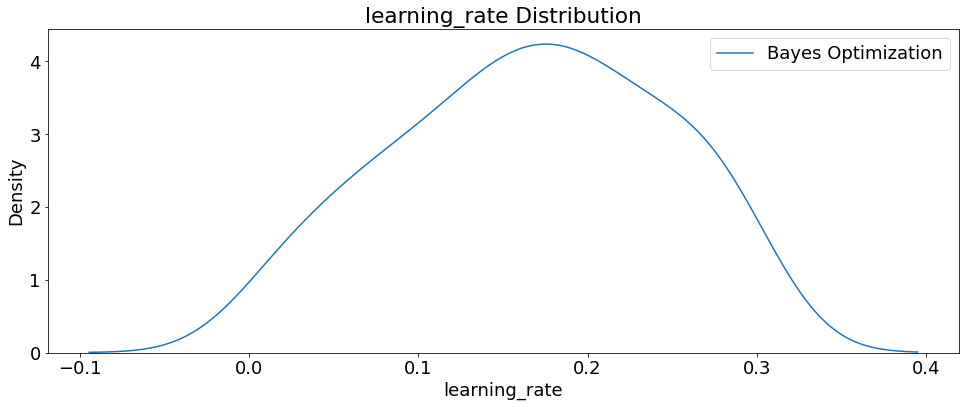

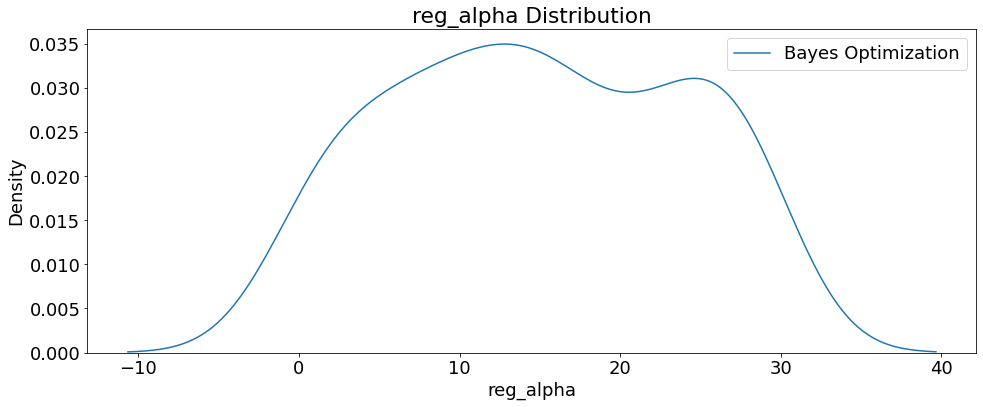

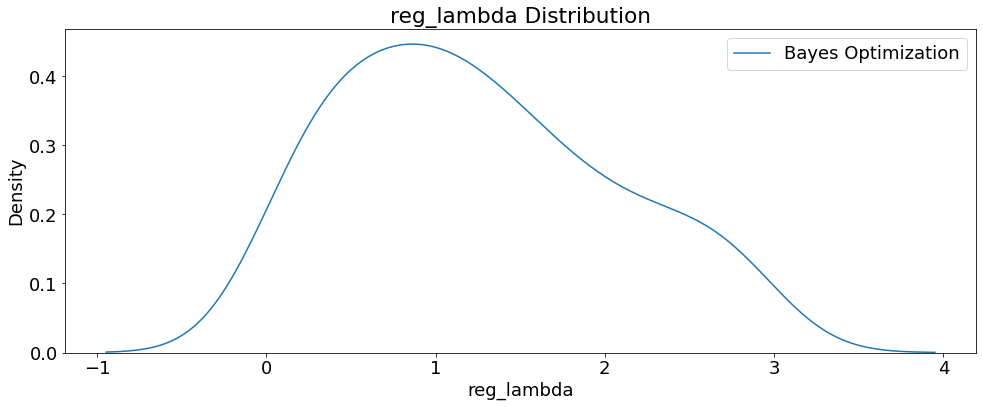

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                     'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

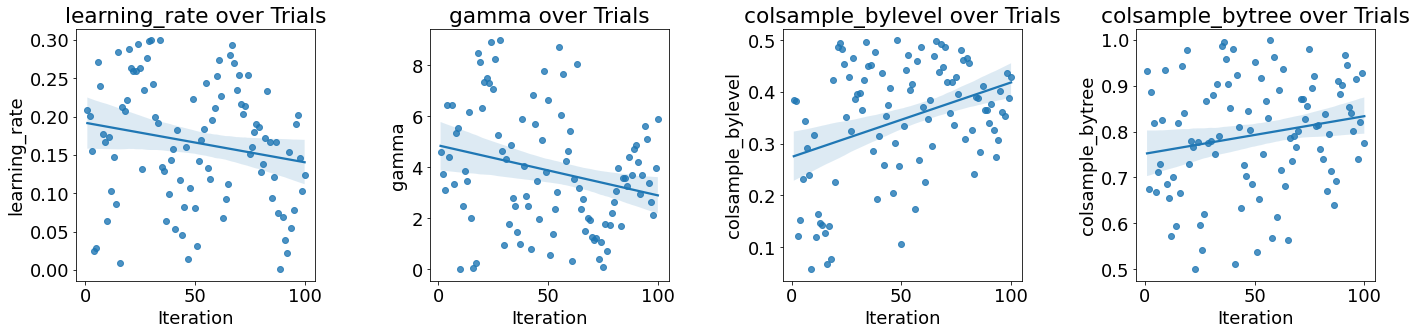

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


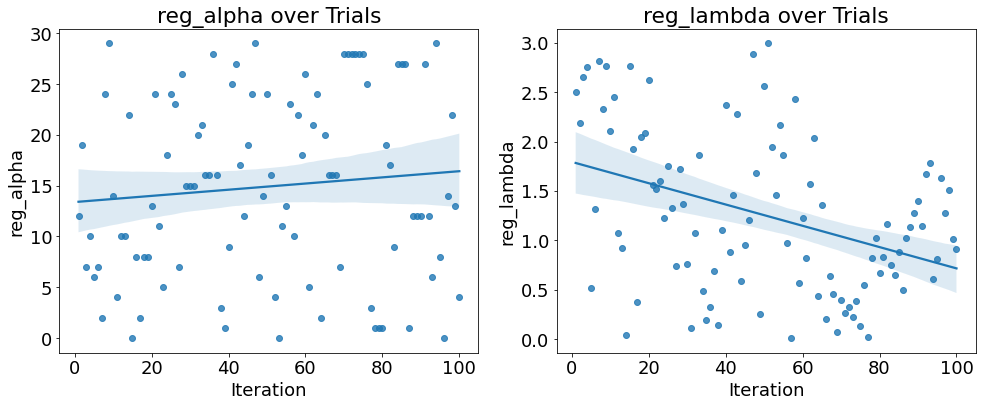

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

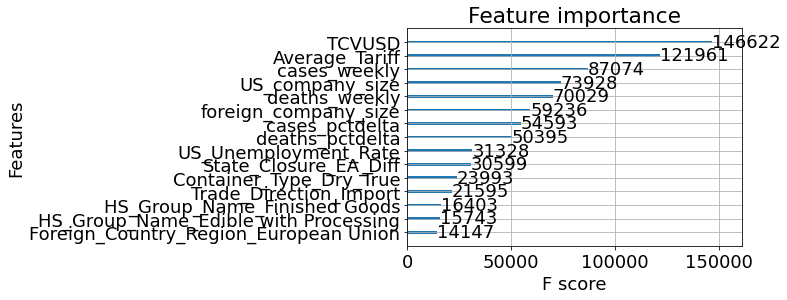

In [ ]:
# Plot the feature importance from best model result
my_dpi=96

plot_importance(best_bayes_model, max_num_features = 15)

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test1.columns.tolist())

html_obj 

Weight,Feature
0.8797 ± 0.0017,TCVUSD
0.3086 ± 0.0012,Average_Tariff
0.1330 ± 0.0012,HS_Group_Name_Finished Goods
0.1278 ± 0.0020,Trade_Direction_Import
0.1233 ± 0.0018,HS_Group_Name_Raw Input
0.0768 ± 0.0011,deaths_weekly
0.0749 ± 0.0012,cases_pctdelta
0.0625 ± 0.0008,cases_weekly
0.0522 ± 0.0011,Container_Type_Dry_True
0.0499 ± 0.0008,State_Closure_EA_Diff


In [ ]:
################################################################################
################### Test trained model on 2020 on 2018-19 ######################
################################################################################

In [31]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [32]:
# Read data
df = pd.read_csv('MaritimeTrade_10-19_MLP.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (23259149, 13)


In [33]:
# Subset years for training
df = df.loc[(df['Year']>=2018) & (df['Year']< 2020)]

In [34]:
# Examine distribution of year data
df[['Year']].value_counts()

Year
2018    3080375
2019    2978984
dtype: int64

In [35]:
# Drop year variable
df = df.drop(['Year'], axis=1)

In [36]:
# Create variables that did not exist preCOVID to match with COVID data
df = df.copy()
df.loc[:,'cases_weekly'] = 0
df.loc[:,'deaths_weekly'] = 0
df.loc[:,'State_Closure_EA_Diff'] = 0
df.loc[:,'cases_pctdelta'] = 0
df.loc[:,'deaths_pctdelta'] = 0

df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('str')
df['Container_Type_Dry'] = df['Container_Type_Dry'].replace('0','False')
df['Container_Type_Dry'] = df['Container_Type_Dry'].replace('1','True')

In [37]:
# Rename to match variable format in 2018-19
df.rename(columns = {'us_company_size': 'US_company_size'}, inplace = True) 

In [38]:
# Prepare 2018-19 to fit model train on 2020
X_test1 = df.drop(['Metric_Tons'],axis=1)
y_test1 = df['Metric_Tons']

In [39]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [40]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [41]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.fit_transform(X_test1), columns = X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeImportsExports/ML/Xgboost/Model_PKL/

In [43]:
# Re-create the best model and train on the training data
best_bayes_model_1819 = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    random_state = seed_value, 
                                    **best_bayes_params)

# Fit the model
best_bayes_model_1819.fit(X_test1, y_test1)

# Save model
Pkl_Filename = 'Xgboost_HPO_train2020_test1819_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_train2020_test1819_100_GPU.pkl')
# print(model)
# =============================================================================

In [44]:
# Model Metrics
print('\nModel Metrics for Xgboost HPO Train 2020 Test 2018-19')
y_test_pred = best_bayes_model_1819.predict(X_test1)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for Xgboost HPO Train 2020 Test 2018-19
MSE train: 67.536, test: 55360.890
RMSE train: 8.218, test: 235.289
R^2 train: 0.891, test: 0.844


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeImportsExports/ML/Xgboost/Model_Explanations/

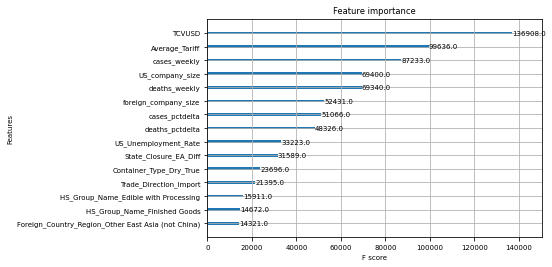

In [45]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model_1819, max_num_features = 15)
plt.savefig('Xgboost_HPO_train20test1819_100_GPU_FeatureImportance.png',
            dpi=my_dpi * 10, bbox_inches='tight')

In [47]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model_1819)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

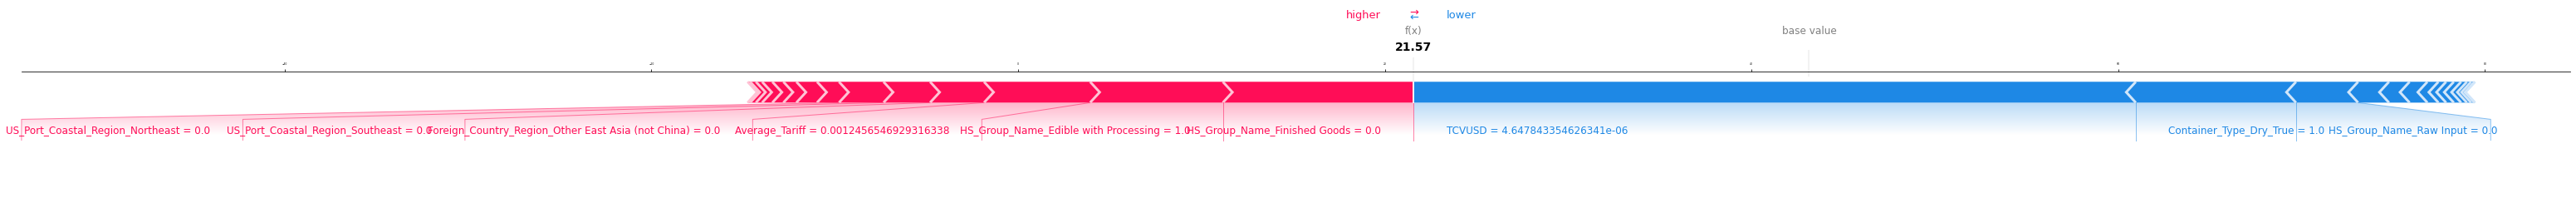

In [63]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55, 3)).savefig('Xgboost_HPO_100_GPU_train20test1819_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

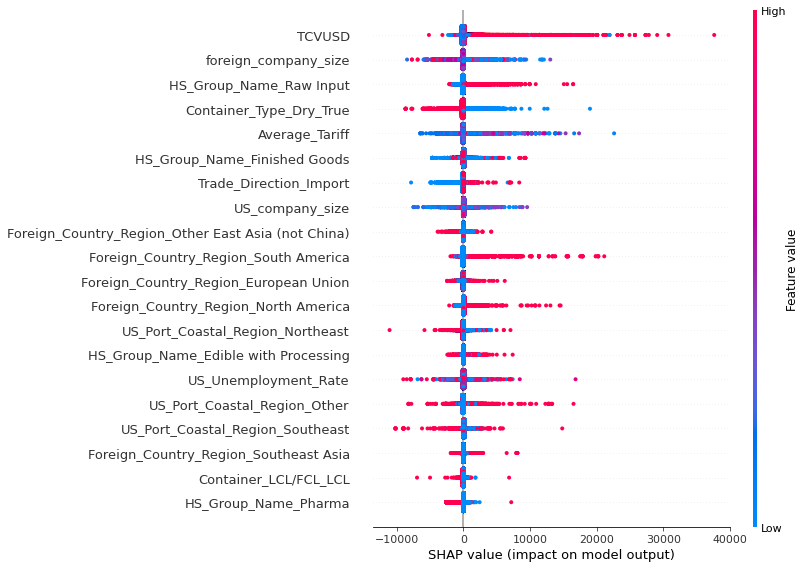

In [49]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('Xgboost_HPO_100_GPU_train20test1819_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model_1819,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_train.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/ML/Xgboost/Model_Explanations/best_bayes_train20test1819_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/ML/Xgboost/Model_Explanations/best_bayes_train20test1819_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
1.1250 ± 0.0110,TCVUSD
0.7557 ± 0.0336,Average_Tariff
0.4706 ± 0.0216,foreign_company_size
0.4546 ± 0.0062,Foreign_Country_Region_Southeast Asia
0.3835 ± 0.0235,Container_Type_Dry_True
0.3355 ± 0.0069,Trade_Direction_Import
0.2341 ± 0.0097,US_company_size
0.1972 ± 0.0320,Foreign_Country_Region_Sub Saharan Africa
0.1487 ± 0.0137,Foreign_Country_Region_Middle East & North Africa
0.1473 ± 0.0139,HS_Group_Name_Finished Goods


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeImportsExports/ML/Xgboost/bestBayes_WeightsExplain/

In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_train.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test1819_HPO_100_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')